## TODO

* update slides
* what can we conclude from these visualizations

To analyize:
* voor de duration analysis moeten we alle participanten includeren
* voor de arousal valance analyis moeten we de participanten excluderen die dezelfde pictures meerde malen hebben beschreven.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import sys

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir, speech_web_app_image_dir


pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))
print(df_session.shape)

# Sanity check: we should have no duplicate pic_names for the same user (ID)
out = df_session[df_session.DB != "marloes"].groupby(["ID", "pic_name"]).size()
display(out[out > 1]) # should be an empty Series
del out


(3257, 23)


Series([], dtype: int64)

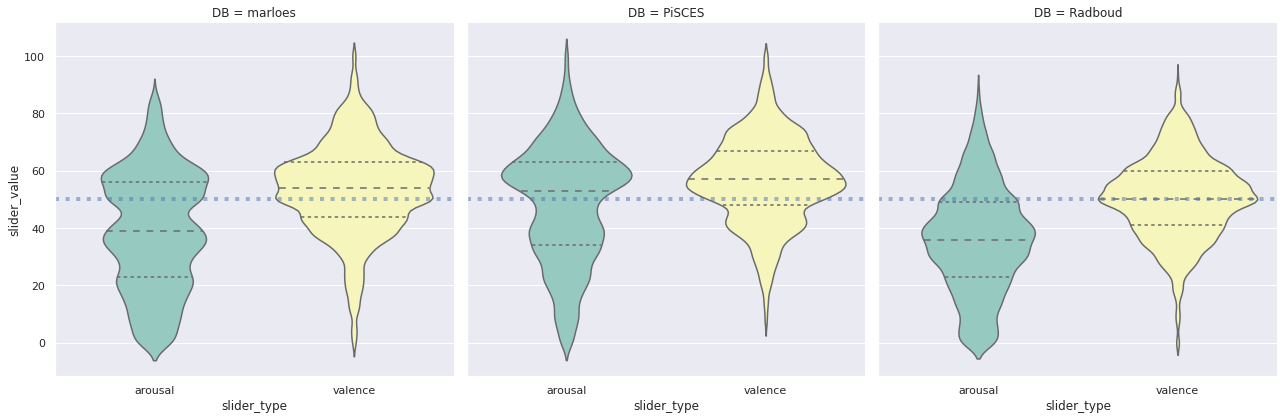

In [3]:
g = sns.catplot(
    data=df_session.melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="violin",
    x="slider_type",
    y="slider_value",
    col="DB",
    palette="Set3",
    bw=0.15,
    inner="quartile",
    col_wrap=3,
    height=6,
)

for ax in g.axes.flat:
    ax.axhline(50, ls=":", lw=4, alpha=0.5)


## Statistics

In [4]:
from scipy.stats import kstest, mannwhitneyu


In [5]:
db_pic_name_var_score_list = []
for db in ["PiSCES", "Radboud"]:
    for pic_name in df_session[df_session.DB == db].pic_name.unique():
        for variable in ["arousal", "valence"]:
            test = mannwhitneyu(
                df_session[(df_session.DB == db) & (df_session.pic_name == pic_name)][
                    variable
                ],
                df_session[(df_session.DB == db) & (df_session.pic_name != pic_name)][
                    variable
                ],
                alternative="two-sided",
                nan_policy="omit",
            )
            db_pic_name_var_score_list.append([db, pic_name, variable, test.pvalue])


In [7]:
db_pic_name_var_score_list = []
for db in ["PiSCES", "Radboud"]:
    for pic_name in df_session[df_session.DB == db].pic_name.unique():
        for variable in ["arousal", "valence"]:
            test = mannwhitneyu(
                df_session[(df_session.DB == db) & (df_session.pic_name == pic_name)][
                    variable
                ],
                df_session[(df_session.DB == db) & (df_session.pic_name != pic_name)][
                    variable
                ],
                alternative="two-sided",
                nan_policy="omit",
            )
            db_pic_name_var_score_list.append([db, pic_name, variable, test.pvalue])


In [8]:
df = pd.DataFrame(
    db_pic_name_var_score_list, columns=["DB", "pic_name", "variable", "p_value"]
).sort_values(by="p_value")
df[df.p_value < 0.05]


DB                                     pic_name variable  \
20   PiSCES                                   Picture 98  arousal   
1    PiSCES                                  Picture 132  valence   
23   PiSCES                                   Picture 65  valence   
3    PiSCES                                   Picture 56  valence   
18   PiSCES                                   Picture 59  arousal   
49  Radboud    Rafd090_46_Caucasian_male_neutral_frontal  valence   
24   PiSCES                                   Picture 93  arousal   
45  Radboud    Rafd090_49_Caucasian_male_neutral_frontal  valence   
51  Radboud    Rafd090_05_Caucasian_male_neutral_frontal  valence   
25   PiSCES                                   Picture 93  valence   
55  Radboud  Rafd090_57_Caucasian_female_neutral_frontal  valence   
31  Radboud  Rafd090_01_Caucasian_female_neutral_frontal  valence   
57  Radboud    Rafd090_47_Caucasian_male_neutral_frontal  valence   
54  Radboud  Rafd090_57_Caucasian_female_neutral_frontal  arousal   
44  Radboud    Rafd090_49_Caucasian_male_neutral_frontal  arousal   
22   PiSCES                                   Picture 65  arousal   
21   PiSCES                                   Picture 98  valence   
12   PiSCES                                   Picture 80  arousal   
30  Radboud  Rafd090_01_Caucasian_female_neutral_frontal  arousal   
47  Radboud  Rafd090_58_Caucasian_female_neutral_frontal  valence   
7    PiSCES                                   Picture 82  valence   
48  Radboud    Rafd090_46_Caucasian_male_neutral_frontal  arousal   
33  Radboud    Rafd090_36_Caucasian_male_neutral_frontal  valence   

         p_value  
20  6.805043e-13  
1   1.998002e-08  
23  1.034402e-07  
3   1.400692e-07  
18  5.687048e-05  
49  7.821674e-05  
24  9.566546e-05  
45  1.912140e-04  
51  6.211347e-04  
25  6.893457e-04  
55  7.848637e-04  
31  2.071359e-03  
57  2.461501e-03  
54  4.198478e-03  
44  5.603387e-03  
22  6.675360e-03  
21  1.526477e-02  
12  1.973668e-02  
30  2.791331e-02  
47  3.150064e-02  
7   3.238924e-02  
48  4.844303e-02  
33  4.918156e-02

### Inter dataset statistics

In [9]:
display(kstest(df_session.arousal.dropna(), "norm").pvalue)
display(kstest(df_session.valence.dropna(), "norm").pvalue)


0.0

0.0

In [11]:
for variable, (group_a_mask, name_a), (group_b_mask, name_b) in [
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "arousal",
        (df_session.DB == "PiSCES", "PiSCES"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
]:
    test = mannwhitneyu(
        df_session[group_a_mask][variable],
        df_session[group_b_mask][variable],
        nan_policy="omit",
    )
    print(
        "{:10s}\t{:>10s} - {:15s}\t{:20s}".format(
            variable, name_a, name_b, str(test.pvalue)
        )
    )


arousal   	   marloes - not-marloes    	0.0005045374454610141
arousal   	   marloes - PiSCES         	1.901518511319576e-21
arousal   	   marloes - Radboud        	0.0018322203608126296
arousal   	    PiSCES - Radboud        	5.1016210309973966e-58
valence   	   marloes - not-marloes    	0.765455702746452   
valence   	   marloes - PiSCES         	5.575542830390487e-05
valence   	   marloes - Radboud        	4.9566874761545685e-06
valence   	    PisCes - Radboud        	2.0217535164599894e-27


In [11]:
for variable, (group_a_mask, name_a), (group_b_mask, name_b) in [
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "arousal",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "arousal",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB != "marloes", "not-marloes"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "PiSCES", "PiSCES"),
    ),
    (
        "valence",
        (df_session.DB == "marloes", "marloes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
    (
        "valence",
        (df_session.DB == "PiSCES", "PisCes"),
        (df_session.DB == "Radboud", "Radboud"),
    ),
]:
    test = mannwhitneyu(
        df_session[group_a_mask][variable],
        df_session[group_b_mask][variable],
        nan_policy="omit",
    )
    print(
        "{:10s}\t{:>10s} - {:15s}\t{:20s}".format(
            variable, name_a, name_b, str(test.pvalue)
        )
    )


arousal   	   marloes - not-marloes    	0.00031038343178226854
arousal   	   marloes - PiSCES         	8.580945499527095e-21
arousal   	   marloes - Radboud        	0.006464149276320611
arousal   	    PisCes - Radboud        	9.240228031702116e-54
valence   	   marloes - not-marloes    	0.711132545084249   
valence   	   marloes - PiSCES         	0.00014025606254519126
valence   	   marloes - Radboud        	7.6015394871832045e-06
valence   	    PisCes - Radboud        	5.963590990517031e-26


In [12]:
# * 2 modellen ; 1 met afh. var. arousal, andere valence.
# * fixed-effect = dataset
# * random effect = user_id

# dan nog kijken of andere variabelen een significant contributor zijn
# (Bv. een model met of zonder age als fixed effect)

# generalized linear mixed effects model
# -> kijken naar de fit afh. van de onderliggende distributie die je gebruikt
# ->


# Fig & arousal valence distribution

In [12]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes["x"].join(target, ax)
        if sharey:
            target._shared_axes["y"].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1, :].flat:
            ax.xaxis.set_tick_params(which="both", labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:, 1:].flat:
            ax.yaxis.set_tick_params(which="both", labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)


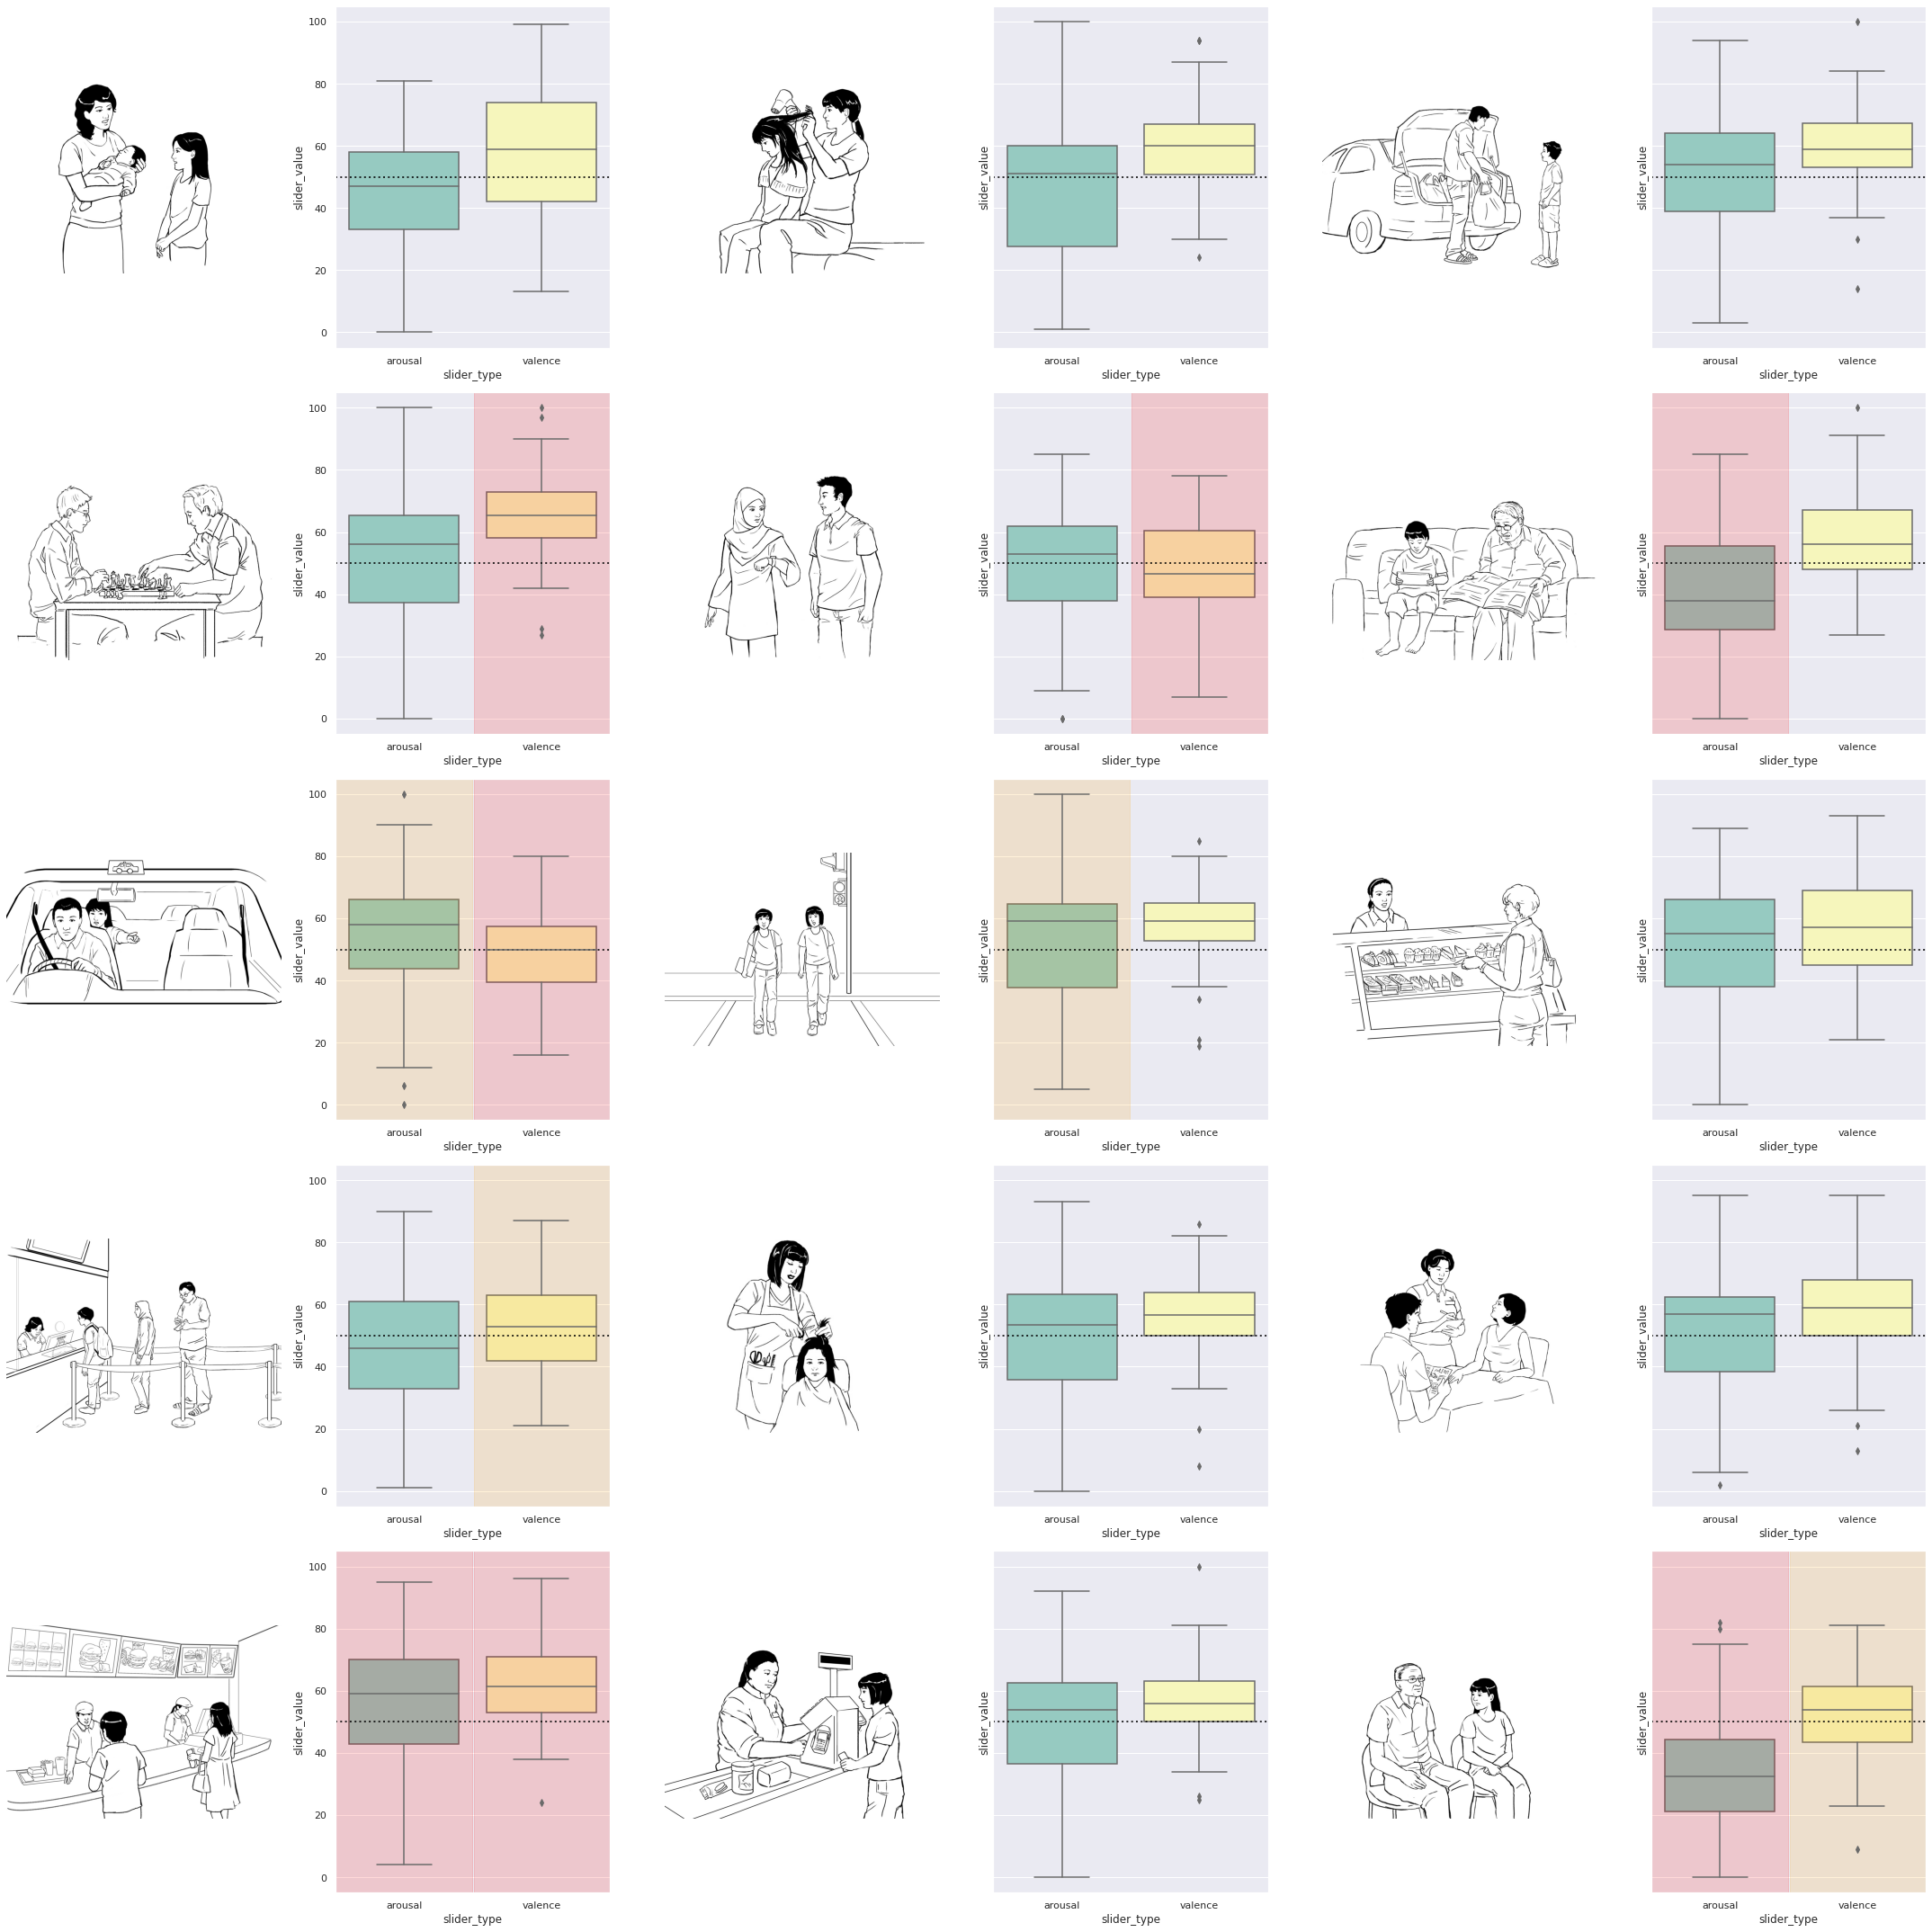

In [15]:
n_cols = 6
DB = "PiSCES"
fig, axs = plt.subplots(nrows=math.ceil(30 / n_cols), ncols=n_cols, figsize=(30, 30))

set_share_axes(axs=axs[:, 1::2], sharey=True)

for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i * 2

    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    if len(img.shape) == 2:
        img = np.repeat(img, 3).reshape(img.shape + (3,))

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")

    arousal_p = df[
        (df.pic_name == pic_name) & (df.variable == "arousal")
    ].p_value.values[0]
    valence_p = df[
        (df.pic_name == pic_name) & (df.variable == "valence")
    ].p_value.values[0]

    if arousal_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="red", alpha=0.15
        )
    elif arousal_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="orange", alpha=0.15
        )

    if valence_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="red", alpha=0.15
        )
    elif valence_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="orange", alpha=0.15
        )

    sns.boxplot(
        ax=axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols],
        data=df_session[(df_session.DB == DB) & (df_session.pic_name == pic_name)].melt(
            id_vars=set(df_session.columns).difference({"arousal", "valence"}),
            value_vars=["arousal", "valence"],
            var_name="slider_type",
            value_name="slider_value",
        ),
        x="slider_type",
        y="slider_value",
        palette="Set3",
        # bw=0.3,
        # inner="quartile",
    )

for ax in axs[:, 1::2].flat:
    ax.axhline(50, alpha=0.8, lw=2, c='black', ls=":")
    ax.set_ylim(-5, 105)

plt.tight_layout()


In [16]:
fig.savefig("../reports/pisces.png", dpi=100)


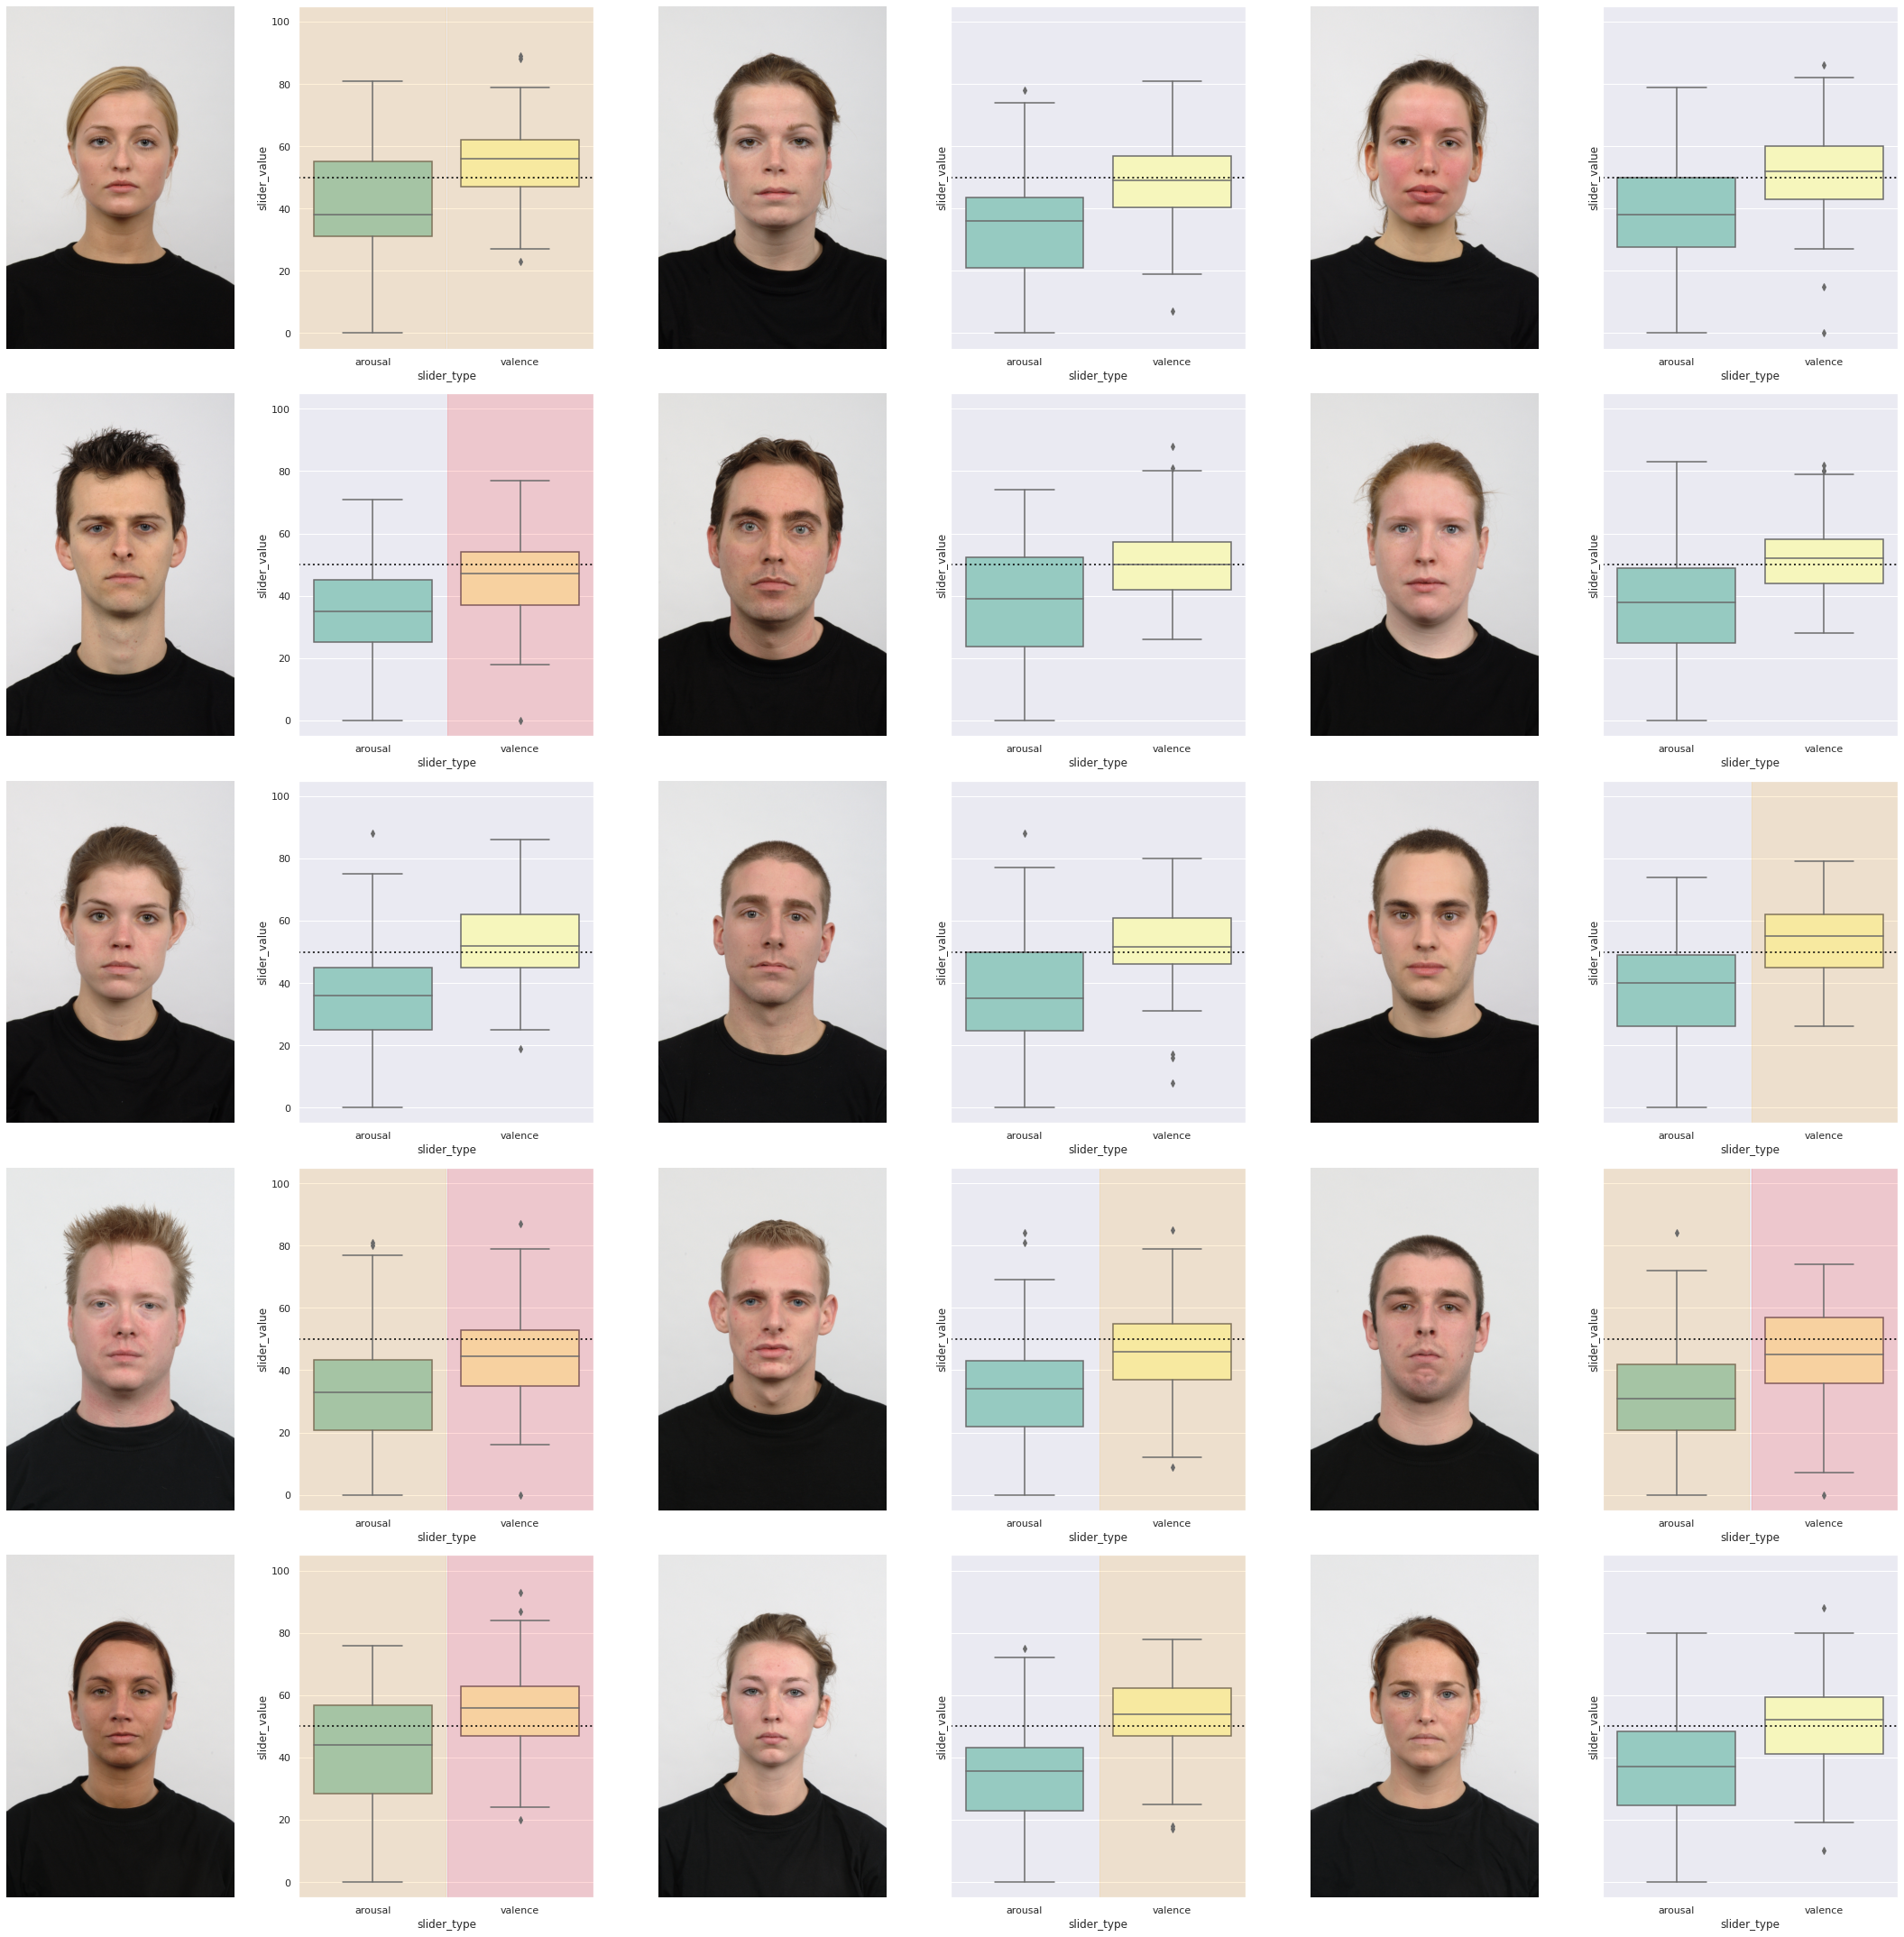

In [17]:
n_cols = 6
DB = "Radboud"
fig, axs = plt.subplots(nrows=math.ceil(30 / n_cols), ncols=n_cols, figsize=(30, 30))

set_share_axes(axs=axs[:, 1::2], sharey=True)

for i, pic_name in enumerate(sorted(df_session[df_session.DB == DB].pic_name.unique())):
    ix2 = i * 2

    with open(
        list(speech_web_app_image_dir.joinpath(DB).glob(f"{pic_name}*"))[0], "rb"
    ) as f:
        img = plt.imread(f)

    axs[ix2 // n_cols, ix2 % n_cols].imshow(img)
    axs[ix2 // n_cols, ix2 % n_cols].axis("off")

    arousal_p = df[
        (df.pic_name == pic_name) & (df.variable == "arousal")
    ].p_value.values[0]
    valence_p = df[
        (df.pic_name == pic_name) & (df.variable == "valence")
    ].p_value.values[0]

    if arousal_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="red", alpha=0.15
        )
    elif arousal_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            -0.5, 0.493, color="orange", alpha=0.15
        )

    if valence_p < 0.001:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="red", alpha=0.15
        )
    elif valence_p < 0.05:
        axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols].axvspan(
            0.507, 1.5, color="orange", alpha=0.15
        )

    sns.boxplot(
        ax=axs[(ix2 + 1) // n_cols, (ix2 + 1) % n_cols],
        data=df_session[(df_session.DB == DB) & (df_session.pic_name == pic_name)].melt(
            id_vars=set(df_session.columns).difference({"arousal", "valence"}),
            value_vars=["arousal", "valence"],
            var_name="slider_type",
            value_name="slider_value",
        ),
        x="slider_type",
        y="slider_value",
        palette="Set3",
        # bw=0.2,
        # inner="quartile",
    )

for ax in axs[:, 1::2].flat:
    ax.set_ylim(-5, 105)
    ax.axhline(50, alpha=0.8, lw=2, c='black', ls=":")

plt.tight_layout()


In [18]:
fig.savefig("../reports/radboud.png", dpi=100)


# Over time

In [42]:
radboud_index = (
    df_session[df_session.DB == "Radboud"].session_no.value_counts().iloc[:15].index
)
pisces_index = (
    df_session[df_session.DB == "PiSCES"].session_no.value_counts().iloc[:15].index
)
marloes_index = (
    df_session[df_session.DB == "marloes"].session_no.value_counts().iloc[:7].index
)

valid_session_no_mask = (
    (df_session.session_no.isin(marloes_index) & (df_session.DB == "marloes"))
    | (df_session.session_no.isin(radboud_index) & (df_session.DB == "Radboud"))
    | (df_session.session_no.isin(pisces_index) & (df_session.DB == "PiSCES"))
)
print(valid_session_no_mask.value_counts())
del marloes_index, pisces_index, radboud_index


True     3166
False      91
dtype: int64


In [43]:
# display(df_session[(df_session.session_no == 1) & (df_session.DB != "marloes")])
# display(df_session[(df_session.session_no == 2) & (df_session.DB != "PiSCES")])
# display(df_session[df_session.DB == "PiSCES"]["session_no"].unique())
# df_session[
#     (df_session.DB != "marloes")
#     & (df_session.ID != "36996711-b0d1-41f9-974d-65bf8f7746dc")
# ][["DB", "session_no"]].value_counts().sort_index(level=1).to_frame()[:35]
# # pisces starts with session_no 2, 4, 6, (MARLOES), 9, 11
# # radboud starts with session_no 3, 5, (MARLOES) 8, 10, 12


Text(0.5, 1.05, 'Arousal and Valence (orange=PiSCES  -  grey=Marloes  -  no-color=RadBoud)')

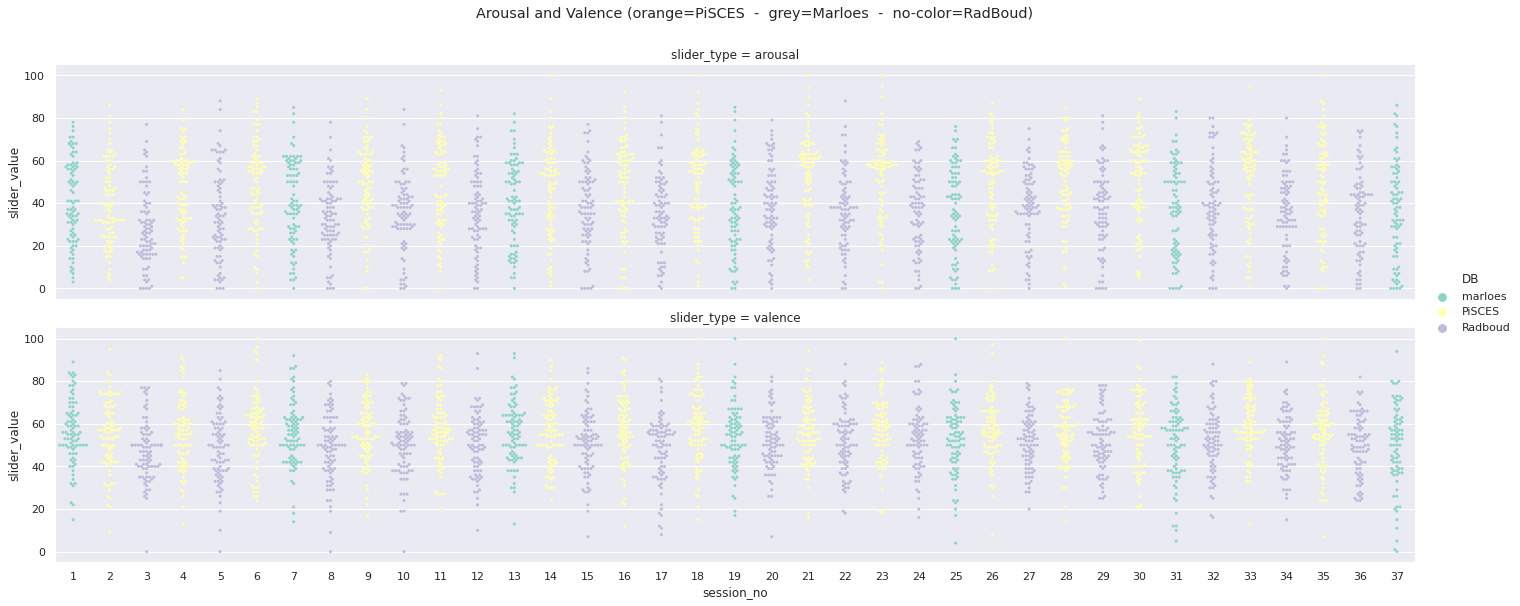

In [63]:
g = sns.catplot(
    data=df_session[valid_session_no_mask ].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="swarm",
    x="session_no",
    y="slider_value",
    row="slider_type",
    hue='DB',
    palette='Set3',
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=4,
    aspect=5,
    s=3,
)


# for ax in g.axes.flat:
#     for marloes_id in [1, 7, 13, 19, 25, 31, 37]:
#         ax.axvspan(marloes_id - 1.5, marloes_id - 0.5, alpha=0.1, color="black")
#     for pisces_id in [2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26, 28, 30, 33, 35]:
#         ax.axvspan(pisces_id - 1.5, pisces_id - 0.5, alpha=0.1, color="orange")

g.fig.suptitle(
    "Arousal and Valence (orange=PiSCES  -  grey=Marloes  -  no-color=RadBoud)", y=1.05
)


Text(0.5, 1.05, 'Arousal and Valence (orange=PiSCES  -  grey=Marloes  -  no-color=RadBoud)')

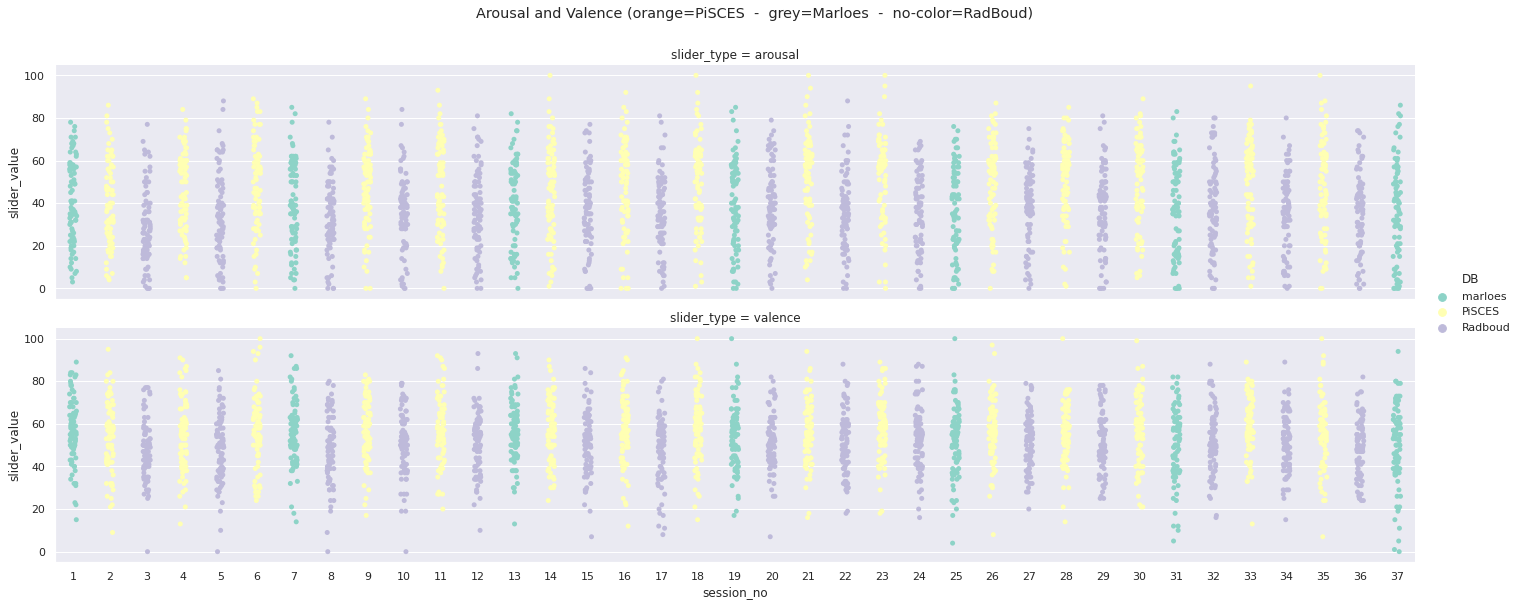

In [ ]:
g = sns.catplot(
    data=df_session[valid_session_no_mask ].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="swarm",
    x="session_no",
    y="slider_value",
    row="slider_type",
    hue='DB',
    palette='Set3',
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=4,
    aspect=5,
)


# for ax in g.axes.flat:
#     for marloes_id in [1, 7, 13, 19, 25, 31, 37]:
#         ax.axvspan(marloes_id - 1.5, marloes_id - 0.5, alpha=0.1, color="black")
#     for pisces_id in [2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26, 28, 30, 33, 35]:
#         ax.axvspan(pisces_id - 1.5, pisces_id - 0.5, alpha=0.1, color="orange")

g.fig.suptitle(
    "Arousal and Valence (orange=PiSCES  -  grey=Marloes  -  no-color=RadBoud)", y=1.05
)


Text(0.5, 1.05, 'Arousal and Valence (orange=PiSCES  -  grey=Marloes  -  no-color=RadBoud)')

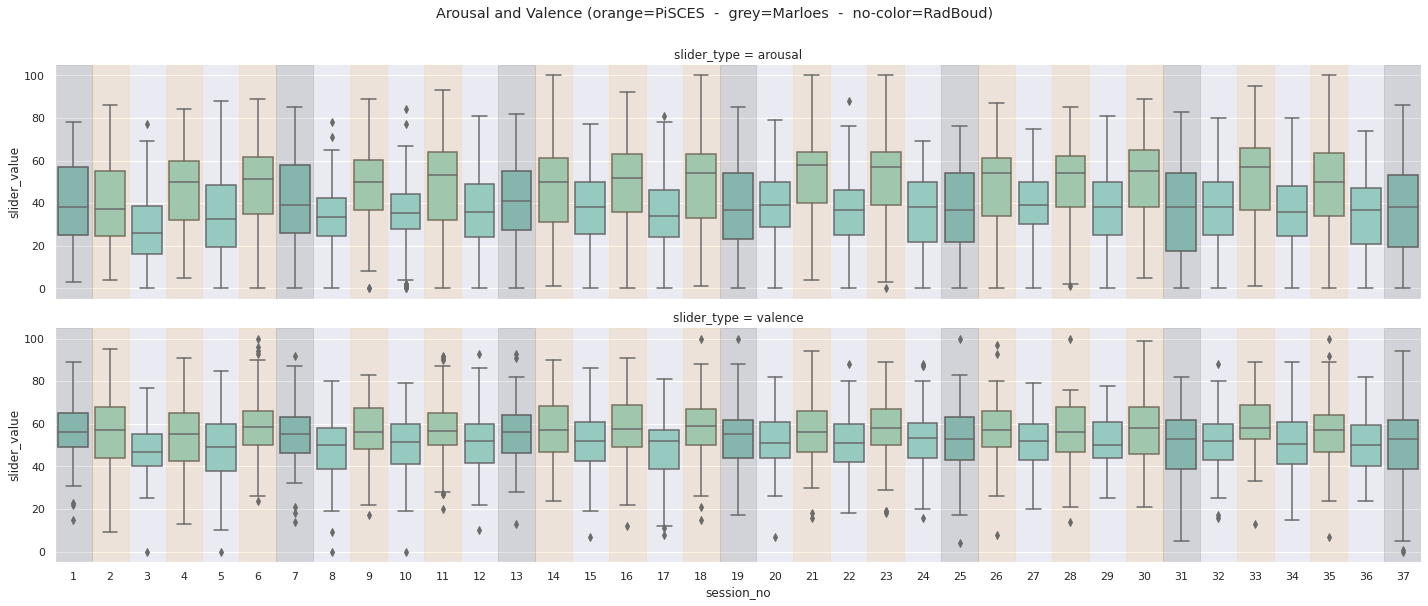

In [66]:

g = sns.catplot(
    data=df_session[valid_session_no_mask ].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="session_no",
    y="slider_value",
    row="slider_type",
    # palette='Set3',
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=4,
    aspect=5,
    # s=3,
)


for ax in g.axes.flat:
    for marloes_id in [1, 7, 13, 19, 25, 31, 37]:
        ax.axvspan(marloes_id - 1.5, marloes_id - 0.5, alpha=0.1, color="black")
    for pisces_id in [2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26, 28, 30, 33, 35]:
        ax.axvspan(pisces_id - 1.5, pisces_id - 0.5, alpha=0.1, color="orange")

g.fig.suptitle(
    "Arousal and Valence (orange=PiSCES  -  grey=Marloes  -  no-color=RadBoud)", y=1.05
)


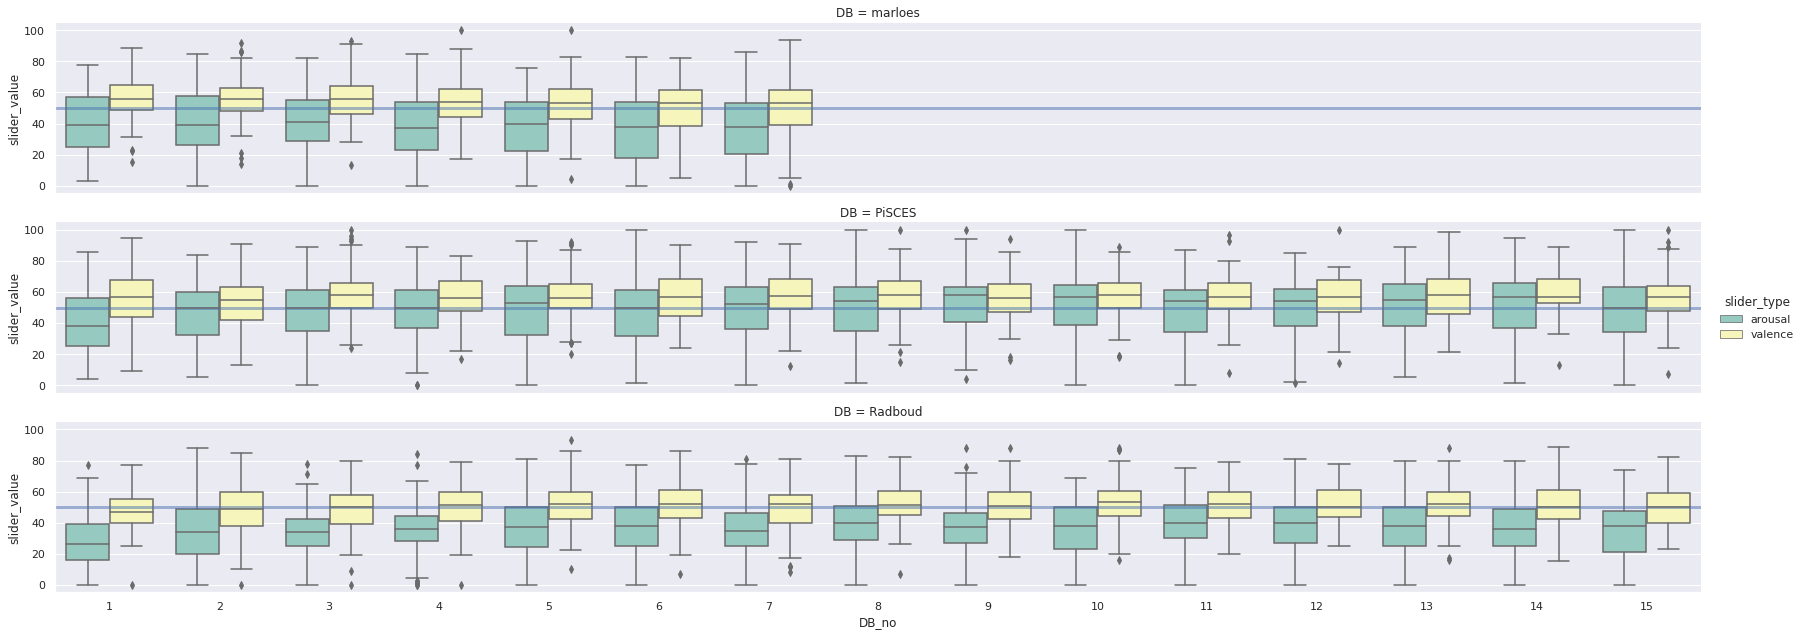

In [ ]:
g = sns.catplot(
    data=df_session[df_session.DB_no < 16].melt(
        id_vars=set(df_session.columns).difference({"arousal", "valence"}),
        value_vars=["arousal", "valence"],
        var_name="slider_type",
        value_name="slider_value",
    ),
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="DB_no",
    y="slider_value",
    hue="slider_type",
    row="DB",
    palette="Set3",
    height=3,
    aspect=8,
)

for ax in g.axes.flat:
    ax.set_ylim(-5, 105)
    ax.axhline(50, alpha=0.5, lw=3)


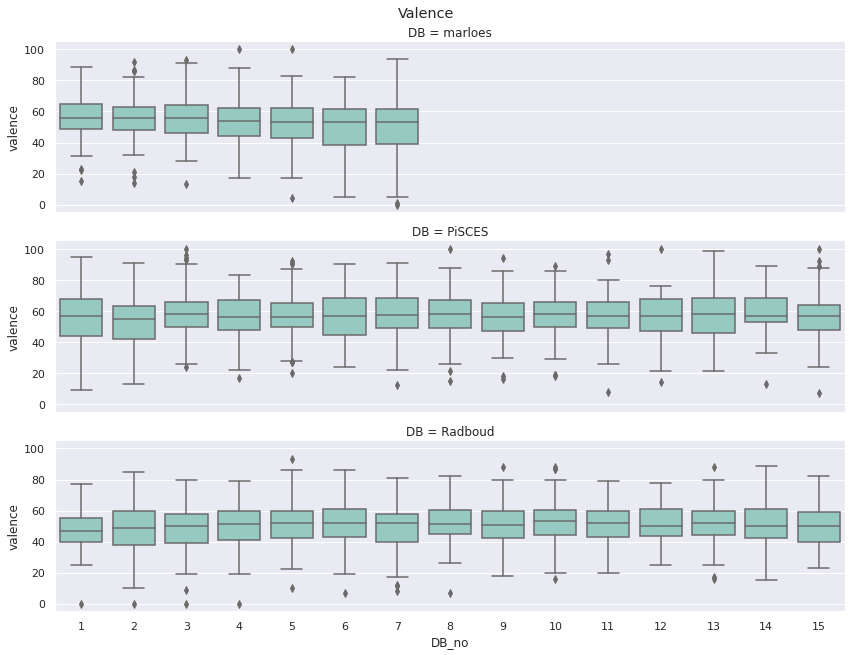

------------------------------------------------------------------------------------------------------------------------


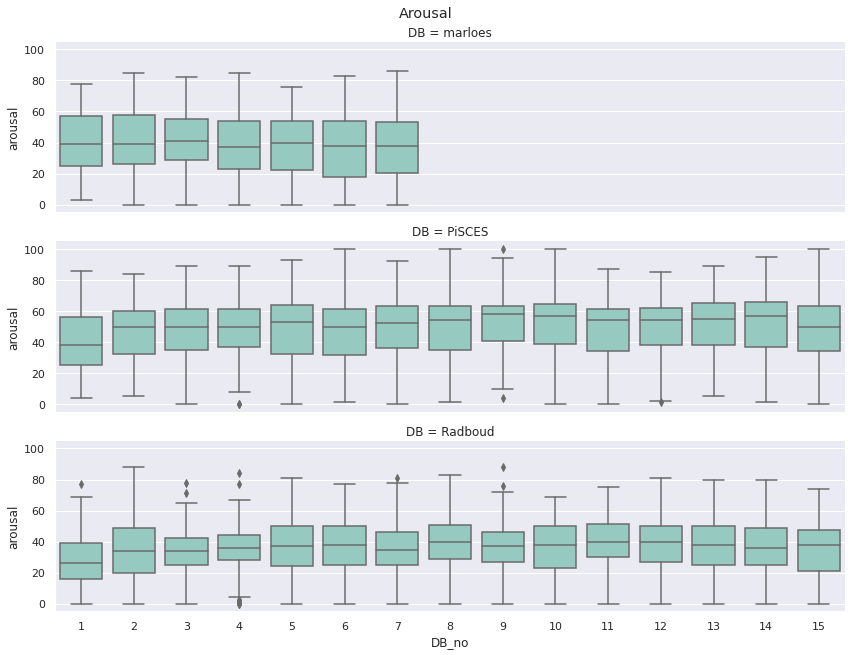

In [49]:
g = sns.catplot(
    data=df_session[df_session.DB_no < 16],
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="DB_no",
    y="valence",
    row="DB",
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=3,
    aspect=4,
)
g.fig.suptitle("Valence", y=1.01)
plt.show()

print("-" * 120)
g = sns.catplot(
    data=df_session[df_session.DB_no < 16],
    sharex=True,
    sharey=True,
    legend=True,
    kind="box",
    x="DB_no",
    y="arousal",
    row="DB",
    # color='lightseagreen',
    color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    height=3,
    aspect=4,
)
g.fig.suptitle("Arousal", y=1.01)
plt.show()
